In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [18]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)
random.seed(42)

print("🎵 Librerías cargadas exitosamente!")

🎵 Librerías cargadas exitosamente!


In [19]:
# Configuración del dataset
DATASET_PATH = "tracks_features_500.csv"  # 🔧 CAMBIAR POR TU RUTA
SAMPLE_SIZE = 500
RANDOM_STATE = 42

# Características musicales para clustering
MUSICAL_FEATURES = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'
]

print(f"🎯 Configuración:")
print(f"   Dataset: {DATASET_PATH}")
print(f"   Muestra: {SAMPLE_SIZE} canciones")
print(f"   Features: {len(MUSICAL_FEATURES)} características")

🎯 Configuración:
   Dataset: tracks_features_500.csv
   Muestra: 500 canciones
   Features: 13 características


In [20]:
def load_dataset_sample(dataset_path, sample_size=300, random_state=42):
    """
    Cargar muestra aleatoria del dataset de manera eficiente
    """
    try:
        print(f"🔍 Analizando dataset: {dataset_path}")
        
        # Verificar si el archivo existe
        if not Path(dataset_path).exists():
            print(f"❌ Archivo no encontrado: {dataset_path}")
            print("💡 Asegúrate de que la ruta sea correcta")
            return None
        
        # Para datasets grandes, usar muestreo eficiente
        print("📚 Cargando muestra aleatoria...")
        
        # Opción 1: Si el dataset es manejable (< 500MB)
        try:
            df = pd.read_csv(dataset_path, sep=';', decimal=',', encoding='utf-8', on_bad_lines='skip')
            total_rows = len(df)
            print(f"📊 Dataset cargado: {total_rows:,} canciones")
            
            if total_rows >= sample_size:
                sample_df = df.sample(n=sample_size, random_state=random_state)
                print(f"✅ Muestra creada: {len(sample_df)} canciones")
            else:
                sample_df = df
                print(f"⚠️  Dataset pequeño: usando todas las {len(sample_df)} canciones")
            
            return sample_df
            
        except MemoryError:
            print("⚠️  Dataset muy grande, usando muestreo por chunks...")
            
            # Opción 2: Muestreo eficiente para datasets grandes
            # Contar filas primero
            total_rows = sum(1 for line in open(dataset_path)) - 1
            print(f"📊 Total de filas: {total_rows:,}")
            
            # Generar índices aleatorios
            random_indices = sorted(np.random.choice(total_rows, size=sample_size, replace=False))
            
            # Leer en chunks y seleccionar filas
            chunk_size = 10000
            sample_data = []
            current_index = 0
            
            for chunk in pd.read_csv(dataset_path, chunksize=chunk_size, sep=';', decimal=',', encoding='utf-8', on_bad_lines='skip'):
                chunk_start = current_index
                chunk_end = current_index + len(chunk)
                
                relevant_indices = [idx for idx in random_indices 
                                  if chunk_start <= idx < chunk_end]
                
                if relevant_indices:
                    relative_indices = [idx - chunk_start for idx in relevant_indices]
                    selected_rows = chunk.iloc[relative_indices]
                    sample_data.append(selected_rows)
                
                current_index = chunk_end
                
                if len(sample_data) > 0 and sum(len(df) for df in sample_data) >= sample_size:
                    break
            
            if sample_data:
                sample_df = pd.concat(sample_data, ignore_index=True)
                print(f"✅ Muestra por chunks creada: {len(sample_df)} canciones")
                return sample_df
            else:
                print("❌ No se pudo crear la muestra")
                return None
                
    except Exception as e:
        print(f"❌ Error al cargar dataset: {e}")
        return None

# Cargar la muestra
sample_df = load_dataset_sample(DATASET_PATH, SAMPLE_SIZE, RANDOM_STATE)

🔍 Analizando dataset: tracks_features_500.csv
📚 Cargando muestra aleatoria...
📊 Dataset cargado: 500 canciones
✅ Muestra creada: 500 canciones


In [21]:
if sample_df is not None:
    print("📋 INFORMACIÓN BÁSICA DEL DATASET:")
    print("=" * 50)
    print(f"🎵 Canciones: {len(sample_df):,}")
    print(f"📊 Columnas: {len(sample_df.columns)}")
    print(f"💾 Memoria: {sample_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Mostrar columnas disponibles
    print(f"\n📋 Columnas disponibles:")
    for i, col in enumerate(sample_df.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Verificar características musicales
    available_features = [f for f in MUSICAL_FEATURES if f in sample_df.columns]
    missing_features = [f for f in MUSICAL_FEATURES if f not in sample_df.columns]
    
    print(f"\n🎼 Características musicales:")
    print(f"   ✅ Disponibles: {len(available_features)}/{len(MUSICAL_FEATURES)}")
    print(f"   📊 {available_features}")
    
    if missing_features:
        print(f"   ❌ Faltantes: {missing_features}")
    
    # Mostrar ejemplos de canciones
    print(f"\n🎵 EJEMPLOS DE CANCIONES:")
    print("-" * 40)
    display_cols = []
    for col in ['name', 'artists', 'album']:
        if col in sample_df.columns:
            display_cols.append(col)
    
    if display_cols:
        for i, (_, row) in enumerate(sample_df[display_cols].head().iterrows()):
            if len(display_cols) >= 2:
                print(f"{i+1}. \"{row[display_cols[0]]}\" - {row[display_cols[1]]}")
            else:
                print(f"{i+1}. {row[display_cols[0]]}")
else:
    print("❌ No se pudo cargar el dataset. Verifica la ruta del archivo.")

📋 INFORMACIÓN BÁSICA DEL DATASET:
🎵 Canciones: 500
📊 Columnas: 24
💾 Memoria: 0.29 MB

📋 Columnas disponibles:
   1. id
   2. name
   3. album
   4. album_id
   5. artists
   6. artist_ids
   7. track_number
   8. disc_number
   9. explicit
  10. danceability
  11. energy
  12. key
  13. loudness
  14. mode
  15. speechiness
  16. acousticness
  17. instrumentalness
  18. liveness
  19. valence
  20. tempo
  21. duration_ms
  22. time_signature
  23. year
  24. release_date

🎼 Características musicales:
   ✅ Disponibles: 13/13
   📊 ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

🎵 EJEMPLOS DE CANCIONES:
----------------------------------------
1. "After Going Out" - ['Zorras']
2. "Another Girl's Paradise" - ['Tori Amos']
3. "Still Alive and Well" - ['Johnny Winter']
4. "The Diner" - ['Ani DiFranco']
5. "Time" - ['zebrahead']


In [22]:
def clean_musical_features(df, features):
    """
    Limpiar y preparar características musicales para clustering
    """
    print("🧹 Limpiando características musicales...")
    
    cleaned_df = df.copy()
    cleaning_stats = {
        'original_rows': len(df),
        'features_processed': 0,
        'null_values_fixed': 0,
        'outliers_handled': 0
    }
    
    # Definir rangos válidos para características de Spotify
    feature_ranges = {
        'danceability': (0, 1),
        'energy': (0, 1),
        'speechiness': (0, 1),
        'acousticness': (0, 1),
        'instrumentalness': (0, 1),
        'liveness': (0, 1),
        'valence': (0, 1),
        'key': (0, 11),
        'mode': (0, 1),
        'tempo': (30, 300),
        'loudness': (-80, 10),
        'duration_ms': (10000, 1800000),  # 10 seg a 30 min
        'time_signature': (1, 7)
    }
    
    for feature in features:
        if feature in cleaned_df.columns:
            print(f"  🔧 Procesando: {feature}")
            
            # Convertir a numérico
            cleaned_df[feature] = pd.to_numeric(cleaned_df[feature], errors='coerce')
            
            # Contar valores nulos
            null_count = cleaned_df[feature].isnull().sum()
            if null_count > 0:
                # Rellenar con mediana
                median_val = cleaned_df[feature].median()
                cleaned_df[feature].fillna(median_val, inplace=True)
                cleaning_stats['null_values_fixed'] += null_count
                print(f"    ✅ {null_count} valores nulos → mediana ({median_val:.3f})")
            
            # Manejar outliers usando rangos válidos
            if feature in feature_ranges:
                min_val, max_val = feature_ranges[feature]
                outliers = (cleaned_df[feature] < min_val) | (cleaned_df[feature] > max_val)
                outlier_count = outliers.sum()
                
                if outlier_count > 0:
                    # Clip valores a rangos válidos
                    cleaned_df[feature] = cleaned_df[feature].clip(min_val, max_val)
                    cleaning_stats['outliers_handled'] += outlier_count
                    print(f"    ✅ {outlier_count} outliers → rango [{min_val}, {max_val}]")
            
            cleaning_stats['features_processed'] += 1
    
    print(f"\n📊 Resumen de limpieza:")
    print(f"   🎵 Filas procesadas: {cleaning_stats['original_rows']}")
    print(f"   🔧 Features limpiadas: {cleaning_stats['features_processed']}")
    print(f"   🔄 Valores nulos corregidos: {cleaning_stats['null_values_fixed']}")
    print(f"   📏 Outliers manejados: {cleaning_stats['outliers_handled']}")
    
    return cleaned_df, cleaning_stats

# Aplicar limpieza si tenemos los datos
if sample_df is not None and available_features:
    cleaned_df, stats = clean_musical_features(sample_df, available_features)
    
    # Mostrar estadísticas descriptivas
    print(f"\n📈 ESTADÍSTICAS DESCRIPTIVAS:")
    print("-" * 50)
    feature_stats = cleaned_df[available_features].describe()
    print(feature_stats.round(3))
else:
    print("⚠️  Saltando limpieza - datos no disponibles")

🧹 Limpiando características musicales...
  🔧 Procesando: danceability
  🔧 Procesando: energy
  🔧 Procesando: key
  🔧 Procesando: loudness
  🔧 Procesando: mode
  🔧 Procesando: speechiness
  🔧 Procesando: acousticness
  🔧 Procesando: instrumentalness
  🔧 Procesando: liveness
  🔧 Procesando: valence
  🔧 Procesando: tempo
  🔧 Procesando: duration_ms
  🔧 Procesando: time_signature

📊 Resumen de limpieza:
   🎵 Filas procesadas: 500
   🔧 Features limpiadas: 13
   🔄 Valores nulos corregidos: 0
   📏 Outliers manejados: 0

📈 ESTADÍSTICAS DESCRIPTIVAS:
--------------------------------------------------
       danceability   energy      key  loudness     mode  speechiness  \
count       500.000  500.000  500.000   500.000  500.000      500.000   
mean          0.541    0.591    5.516   -10.172    0.710        0.073   
std           0.152    0.258    3.481     4.138    0.454        0.099   
min           0.066    0.019    0.000   -25.189    0.000        0.023   
25%           0.436    0.390    2.00

📊 Creando visualizaciones exploratorias...


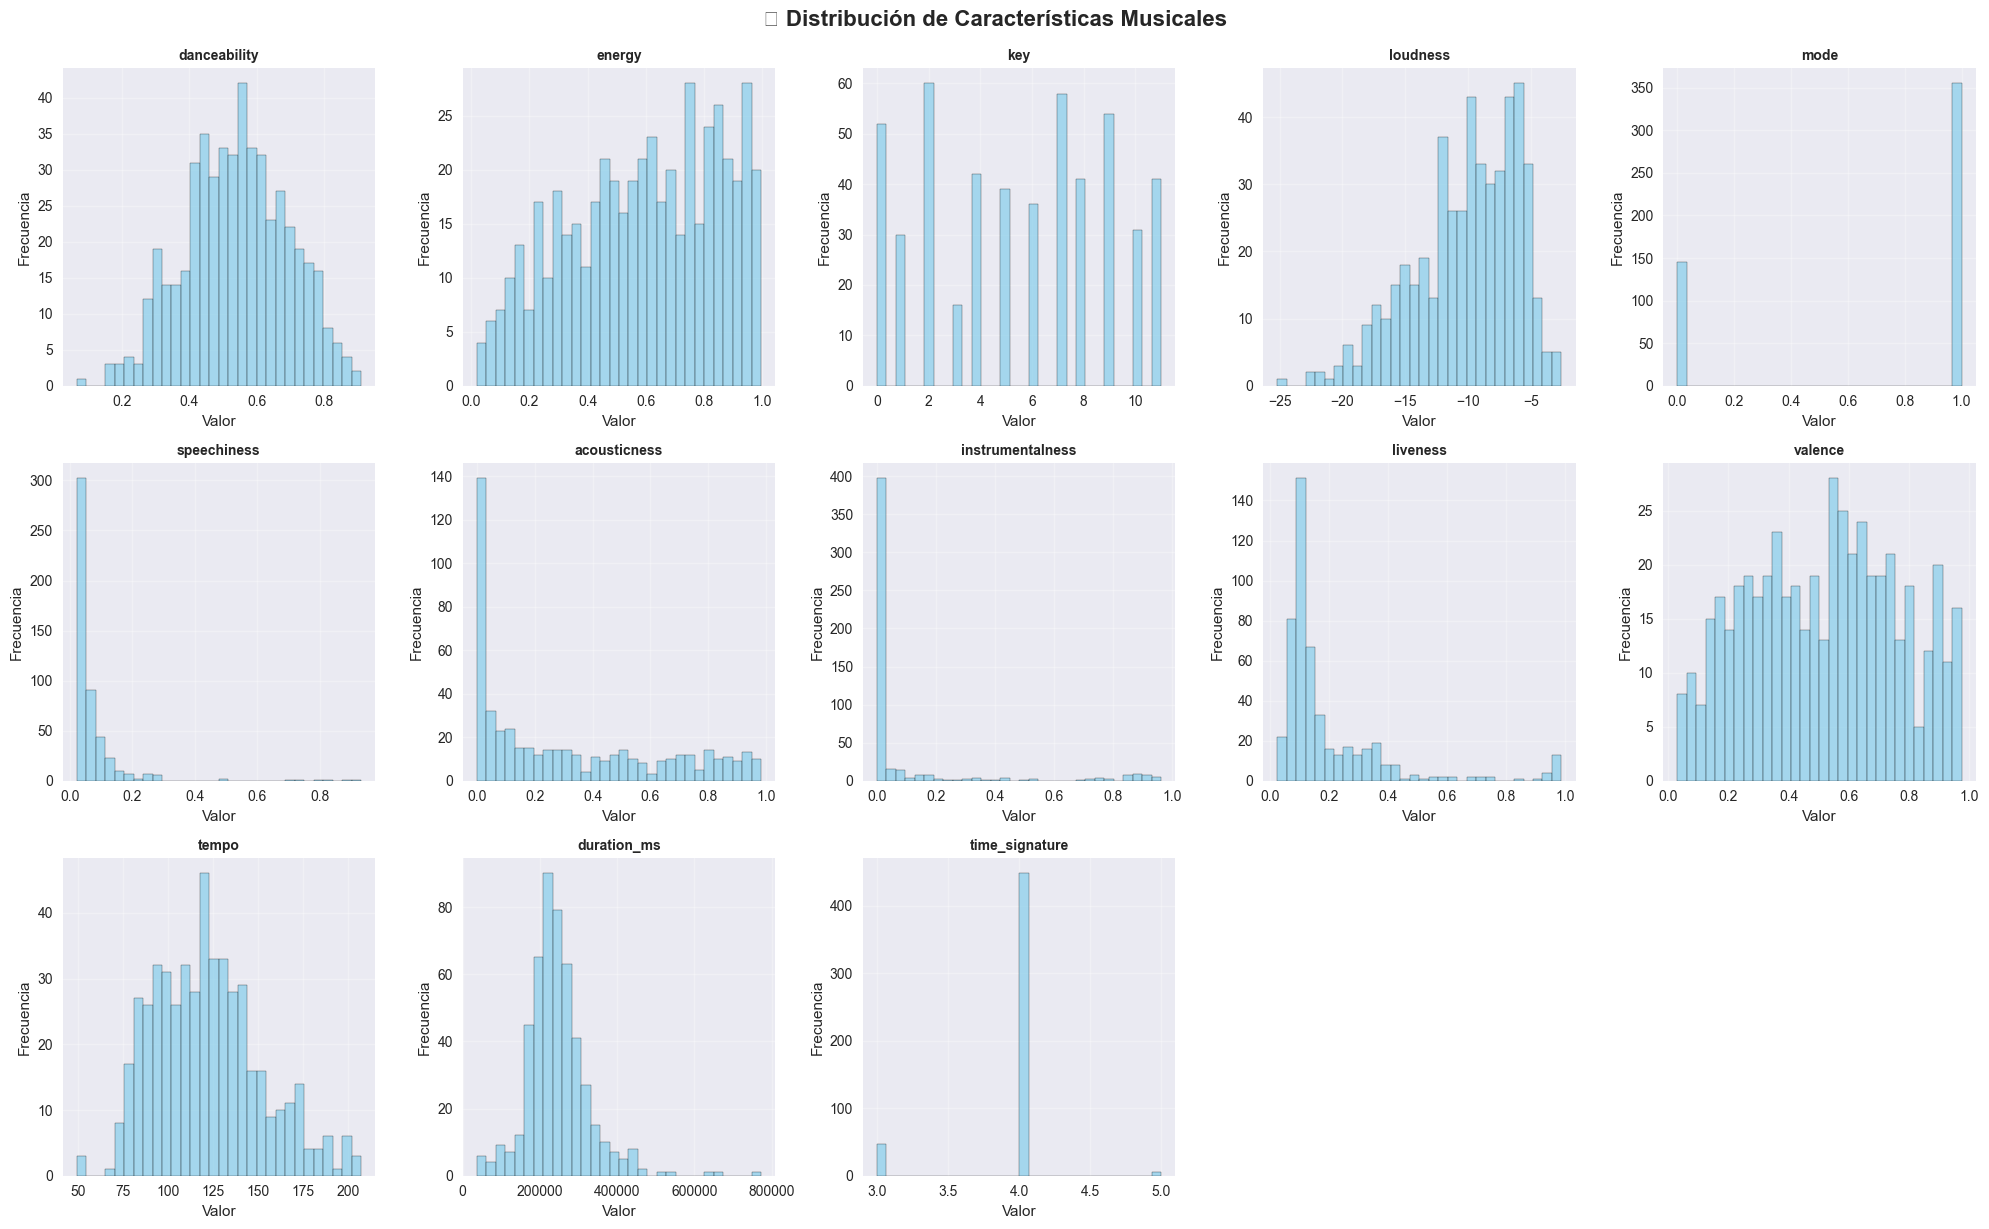

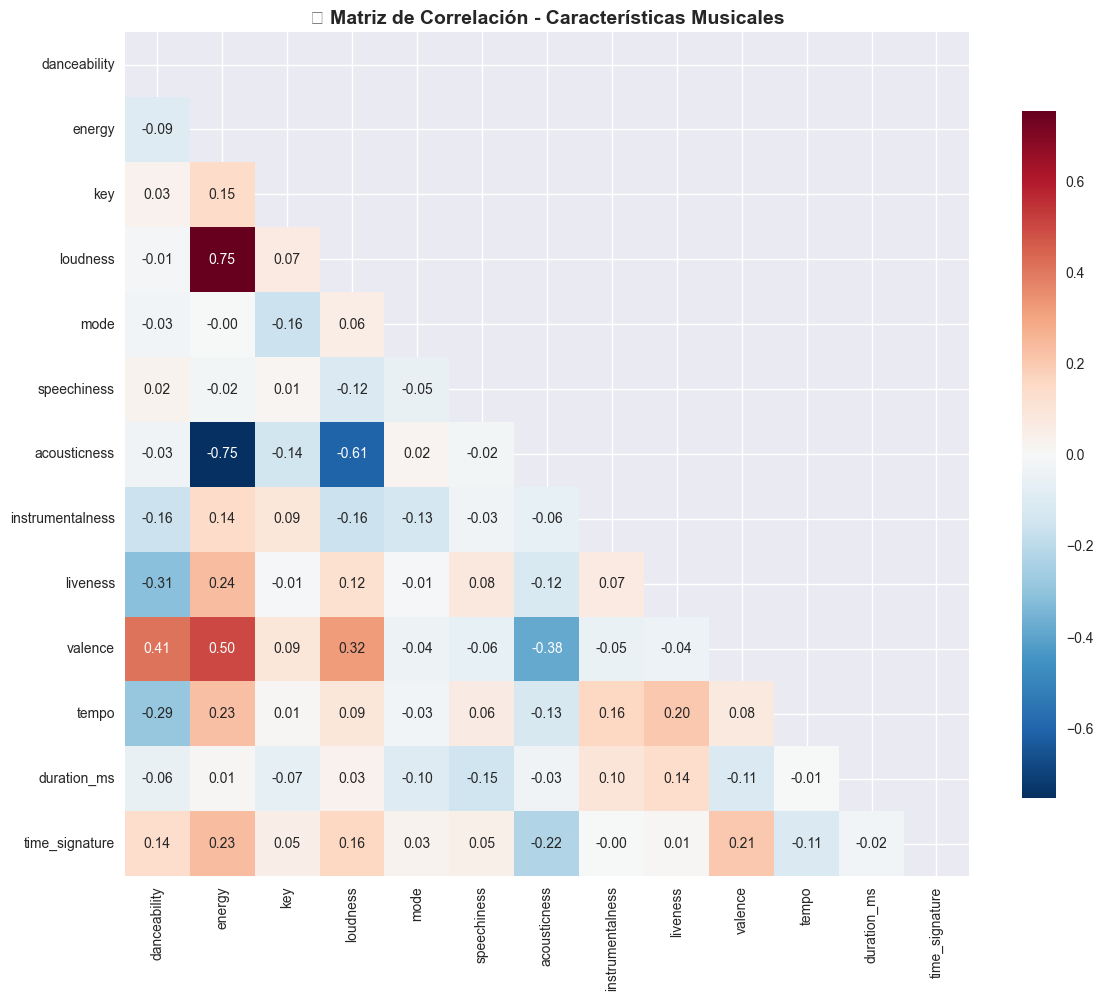

✅ Visualizaciones creadas exitosamente!


In [23]:
if 'cleaned_df' in locals() and len(available_features) > 0:
    # Configurar visualizaciones
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    print("📊 Creando visualizaciones exploratorias...")
    
    for i, feature in enumerate(available_features[:15]):  # Máximo 15 features
        if i < len(axes):
            cleaned_df[feature].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'{feature}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Valor')
            axes[i].set_ylabel('Frecuencia')
            axes[i].grid(True, alpha=0.3)
    
    # Ocultar axes vacíos
    for i in range(len(available_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('🎵 Distribución de Características Musicales', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
    
    # Matriz de correlación
    plt.figure(figsize=(12, 10))
    correlation_matrix = cleaned_df[available_features].corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('🎼 Matriz de Correlación - Características Musicales', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizaciones creadas exitosamente!")
else:
    print("⚠️  Saltando visualizaciones - datos no disponibles")

In [24]:
def prepare_clustering_data(df, features):
    """
    Preparar datos para clustering K-Means
    """
    print("🎯 Preparando datos para clustering...")
    
    # Seleccionar solo características musicales válidas
    clustering_features = [f for f in features if f in df.columns]
    
    if len(clustering_features) == 0:
        print("❌ No hay características válidas para clustering")
        return None, None, None
    
    print(f"🔧 Usando {len(clustering_features)} características:")
    for i, feature in enumerate(clustering_features, 1):
        print(f"  {i:2d}. {feature}")
    
    # Extraer matriz de características
    feature_matrix = df[clustering_features].values
    
    # Normalización con StandardScaler
    scaler = StandardScaler()
    normalized_matrix = scaler.fit_transform(feature_matrix)
    
    print(f"✅ Matriz preparada: {normalized_matrix.shape[0]} canciones × {normalized_matrix.shape[1]} características")
    print(f"📊 Datos normalizados: media ≈ 0, std ≈ 1")
    
    return normalized_matrix, scaler, clustering_features

# Preparar datos para clustering
if 'cleaned_df' in locals():
    clustering_data, scaler, final_features = prepare_clustering_data(cleaned_df, available_features)
    
    if clustering_data is not None:
        print(f"\n🎉 Datos listos para clustering!")
        print(f"   📊 Forma de la matriz: {clustering_data.shape}")
        print(f"   🎼 Características finales: {len(final_features)}")
    else:
        print("❌ No se pudieron preparar los datos para clustering")
else:
    print("⚠️  Datos de entrada no disponibles")

🎯 Preparando datos para clustering...
🔧 Usando 13 características:
   1. danceability
   2. energy
   3. key
   4. loudness
   5. mode
   6. speechiness
   7. acousticness
   8. instrumentalness
   9. liveness
  10. valence
  11. tempo
  12. duration_ms
  13. time_signature
✅ Matriz preparada: 500 canciones × 13 características
📊 Datos normalizados: media ≈ 0, std ≈ 1

🎉 Datos listos para clustering!
   📊 Forma de la matriz: (500, 13)
   🎼 Características finales: 13


🔍 Buscando número óptimo de clusters...
  🤖 Probando K=4...
    📊 Inercia: 4575.5, Silhouette: 0.161
  🤖 Probando K=5...
    📊 Inercia: 4231.9, Silhouette: 0.161
  🤖 Probando K=6...
    📊 Inercia: 3915.1, Silhouette: 0.171
  🤖 Probando K=7...
    📊 Inercia: 3573.0, Silhouette: 0.177
  🤖 Probando K=8...
    📊 Inercia: 3359.0, Silhouette: 0.152
  🤖 Probando K=9...
    📊 Inercia: 3205.6, Silhouette: 0.163
  🤖 Probando K=10...
    📊 Inercia: 3083.0, Silhouette: 0.140
  🤖 Probando K=11...
    📊 Inercia: 2998.7, Silhouette: 0.134


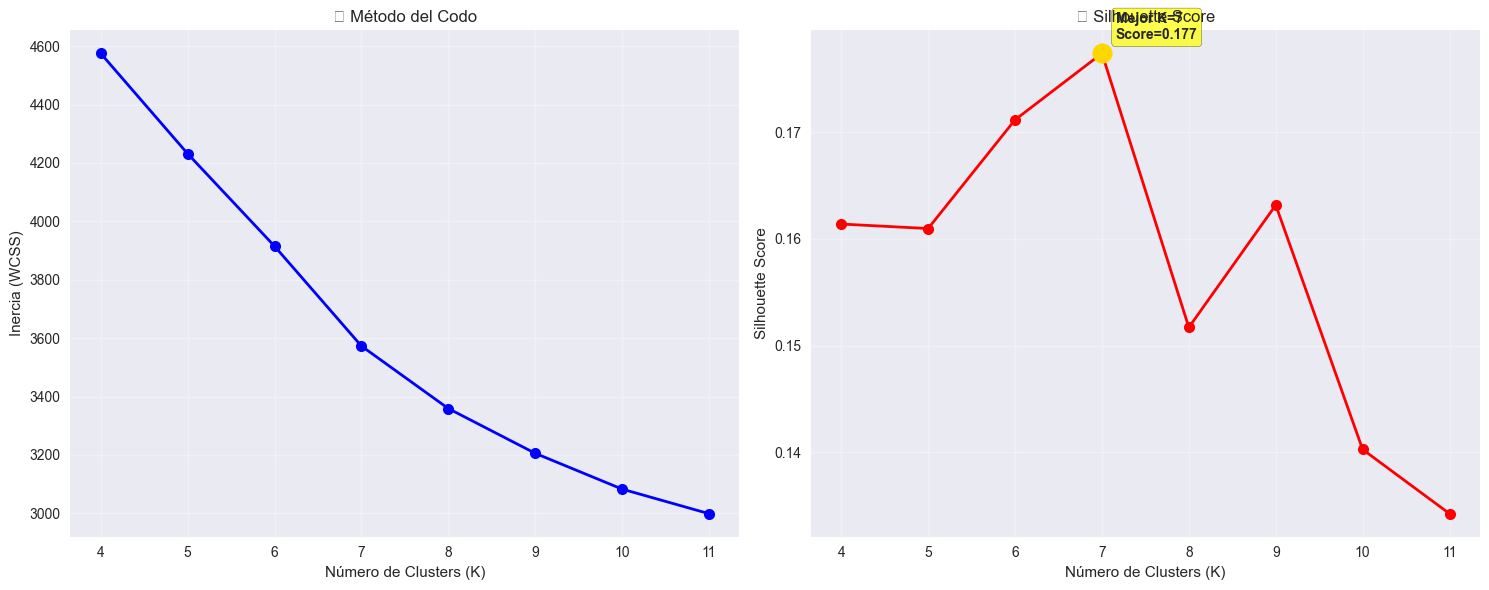


📊 RESULTADOS DE CLUSTERING:
K  | Inercia | Silhouette | Distribución de Clusters
------------------------------------------------------------
 4 |  4575.5 |      0.161 | [227, 147, 39, 87]
 5 |  4231.9 |      0.161 | [124, 42, 84, 38, 212]
 6 |  3915.1 |      0.171 | [96, 205, 115, 34, 7, 43]
 7 |  3573.0 |      0.177 | [42, 197, 110, 7, 37, 26, 81]
 8 |  3359.0 |      0.152 | [91, 7, 104, 125, 36, 42, 25, 70]
 9 |  3205.6 |      0.163 | [100, 70, 24, 28, 41, 139, 12, 79, 7]
10 |  3083.0 |      0.140 | [88, 24, 68, 69, 29, 7, 72, 41, 91, 11]
11 |  2998.7 |      0.134 | [28, 40, 54, 79, 42, 67, 24, 7, 88, 59, 12]

🏆 MEJOR CLUSTERING:
   🎯 K óptimo: 7
   📊 Silhouette Score: 0.177
   📈 Inercia: 3573.0
   🎵 Distribución: [42, 197, 110, 7, 37, 26, 81]


In [28]:
def find_optimal_k(data, k_range=(2, 11), random_state=42):
    """
    Encontrar el número óptimo de clusters usando múltiples métricas
    """
    print("🔍 Buscando número óptimo de clusters...")
    
    results = []
    
    for k in range(k_range[0], k_range[1]):
        print(f"  🤖 Probando K={k}...")
        
        # Aplicar K-Means
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(data)
        
        # Calcular métricas
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(data, labels)
        
        # Contar elementos por cluster
        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_distribution = dict(zip(unique_labels, counts))
        
        results.append({
            'k': k,
            'inertia': inertia,
            'silhouette_score': silhouette_avg,
            'cluster_distribution': cluster_distribution,
            'labels': labels,
            'kmeans_model': kmeans
        })
        
        print(f"    📊 Inercia: {inertia:.1f}, Silhouette: {silhouette_avg:.3f}")
    
    return results

def plot_clustering_metrics(results):
    """
    Visualizar métricas de clustering
    """
    k_values = [r['k'] for r in results]
    inertias = [r['inertia'] for r in results]
    silhouette_scores = [r['silhouette_score'] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Método del codo (Elbow Method)
    ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Número de Clusters (K)')
    ax1.set_ylabel('Inercia (WCSS)')
    ax1.set_title('📈 Método del Codo')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette Score
    ax2.plot(k_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Número de Clusters (K)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('🎯 Silhouette Score')
    ax2.grid(True, alpha=0.3)
    
    # Marcar el mejor K según Silhouette Score
    best_k_idx = np.argmax(silhouette_scores)
    best_k = k_values[best_k_idx]
    best_score = silhouette_scores[best_k_idx]
    
    ax2.scatter([best_k], [best_score], color='gold', s=200, zorder=5)
    ax2.annotate(f'Mejor K={best_k}\nScore={best_score:.3f}', 
                xy=(best_k, best_score), xytext=(10, 10),
                textcoords='offset points', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return best_k

# Ejecutar clustering si tenemos los datos
if 'clustering_data' in locals() and clustering_data is not None:
    # Buscar K óptimo
    clustering_results = find_optimal_k(clustering_data, k_range=(4, 12), random_state=RANDOM_STATE)
    
    # Visualizar métricas
    best_k = plot_clustering_metrics(clustering_results)
    
    # Mostrar resultados tabulares
    print(f"\n📊 RESULTADOS DE CLUSTERING:")
    print("=" * 60)
    print("K  | Inercia | Silhouette | Distribución de Clusters")
    print("-" * 60)
    
    for result in clustering_results:
        distribution = [str(count) for count in result['cluster_distribution'].values()]
        distribution_str = f"[{', '.join(distribution)}]"
        print(f"{result['k']:2d} | {result['inertia']:7.1f} | {result['silhouette_score']:10.3f} | {distribution_str}")
    
    # Encontrar y destacar el mejor resultado
    best_result = max(clustering_results, key=lambda x: x['silhouette_score'])
    
    print(f"\n🏆 MEJOR CLUSTERING:")
    print(f"   🎯 K óptimo: {best_result['k']}")
    print(f"   📊 Silhouette Score: {best_result['silhouette_score']:.3f}")
    print(f"   📈 Inercia: {best_result['inertia']:.1f}")
    print(f"   🎵 Distribución: {list(best_result['cluster_distribution'].values())}")
    
else:
    print("⚠️  No se puede ejecutar clustering - datos no disponibles")

🎼 ANÁLISIS DETALLADO DE CLUSTERS MUSICALES:

🎵 CLUSTER 0 (42 canciones):
----------------------------------------
📊 Características musicales promedio:
  danceability    :  0.454 (±0.113)
  energy          :  0.324 (±0.189)
  key             :  4.548 (±3.610)
  loudness        : -13.255 (±4.064)
  mode            :  0.667 (±0.477)
  speechiness     :  0.054 (±0.038)
  acousticness    :  0.633 (±0.275)
  instrumentalness:  0.063 (±0.199)
  liveness        :  0.157 (±0.102)
  valence         :  0.282 (±0.153)
  tempo           : 128.180 (±34.025)
  duration_ms     : 231303.595 (±99039.242)
  time_signature  :  3.000 (±0.000)

🎤 Ejemplos de canciones:
  1. "In the Details 1" - ['Zorras']
  2. "Disoriented" - ['Reflected Illusions']
  3. "5 To 5" - ['Martin Rev']
  4. "Carbon" - ['Tori Amos']
  5. "Desperate" - ['Death & Desire']


🎵 CLUSTER 1 (197 canciones):
----------------------------------------
📊 Características musicales promedio:
  danceability    :  0.559 (±0.134)
  energy        

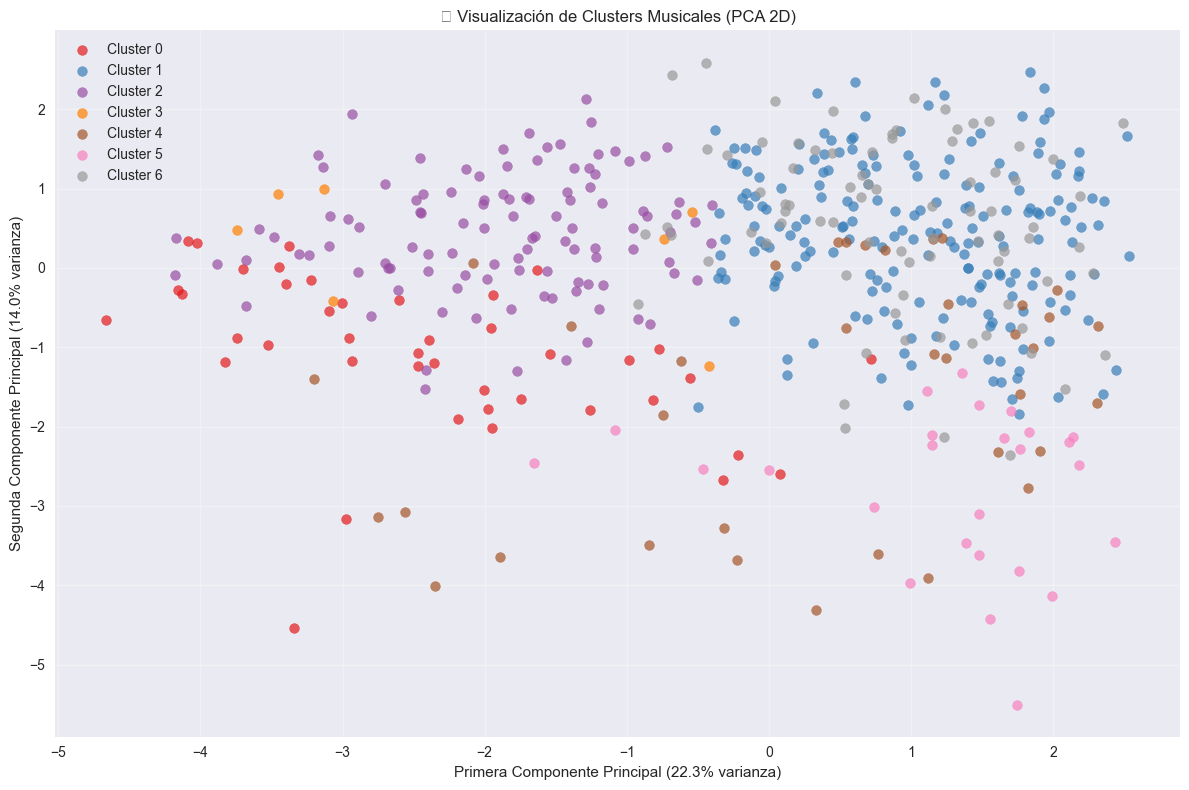

✅ Varianza explicada total: 36.2%

💾 Guardando resultados...
✅ Resultados guardados en: clustering_results.csv


In [29]:
def analyze_music_clusters(df, clustering_result, feature_names, scaler):
    """
    Analizar las características musicales de cada cluster
    """
    print("🎼 ANÁLISIS DETALLADO DE CLUSTERS MUSICALES:")
    print("=" * 60)
    
    labels = clustering_result['labels']
    k = clustering_result['k']
    
    # Añadir labels al dataframe
    analysis_df = df.copy()
    analysis_df['cluster'] = labels
    
    for cluster_id in range(k):
        cluster_songs = analysis_df[analysis_df['cluster'] == cluster_id]
        cluster_size = len(cluster_songs)
        
        print(f"\n🎵 CLUSTER {cluster_id} ({cluster_size} canciones):")
        print("-" * 40)
        
        # Calcular características promedio del cluster
        print("📊 Características musicales promedio:")
        for feature in feature_names:
            if feature in cluster_songs.columns:
                avg_value = cluster_songs[feature].mean()
                std_value = cluster_songs[feature].std()
                print(f"  {feature:16s}: {avg_value:6.3f} (±{std_value:.3f})")
        
        # Mostrar ejemplos de canciones
        print(f"\n🎤 Ejemplos de canciones:")
        display_cols = []
        for col in ['name', 'artists', 'album']:
            if col in cluster_songs.columns:
                display_cols.append(col)
        
        if display_cols:
            examples = cluster_songs[display_cols].head(5)
            for i, (_, song) in enumerate(examples.iterrows()):
                if 'name' in song and 'artists' in song:
                    print(f"  {i+1}. \"{song['name']}\" - {song['artists']}")
                elif 'name' in song:
                    print(f"  {i+1}. \"{song['name']}\"")
                else:
                    print(f"  {i+1}. {song[display_cols[0]]}")
        
        print()
    
    return analysis_df

def create_cluster_visualization(data, labels, feature_names):
    """
    Crear visualización de clusters usando PCA
    """
    print("📊 Creando visualización de clusters...")
    
    # Aplicar PCA para reducir a 2D
    pca = PCA(n_components=2, random_state=42)
    data_2d = pca.fit_transform(data)
    
    # Crear el gráfico
    plt.figure(figsize=(12, 8))
    
    # Colores para cada cluster
    colors = plt.cm.Set1(np.linspace(0, 1, len(np.unique(labels))))
    
    for i, color in enumerate(colors):
        cluster_mask = labels == i
        plt.scatter(data_2d[cluster_mask, 0], data_2d[cluster_mask, 1], 
                   c=[color], label=f'Cluster {i}', alpha=0.7, s=50)
    
    plt.xlabel(f'Primera Componente Principal ({pca.explained_variance_ratio_[0]:.1%} varianza)')
    plt.ylabel(f'Segunda Componente Principal ({pca.explained_variance_ratio_[1]:.1%} varianza)')
    plt.title('🎵 Visualización de Clusters Musicales (PCA 2D)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    total_variance = pca.explained_variance_ratio_.sum()
    print(f"✅ Varianza explicada total: {total_variance:.1%}")
    
    return pca, data_2d

# Ejecutar análisis si tenemos resultados de clustering
if 'clustering_results' in locals() and 'best_result' in locals():
    
    # Analizar clusters musicales
    if 'cleaned_df' in locals():
        analyzed_df = analyze_music_clusters(cleaned_df, best_result, final_features, scaler)
        
        # Crear visualización
        pca_model, data_2d = create_cluster_visualization(clustering_data, best_result['labels'], final_features)
        
        # Guardar resultados
        print(f"\n💾 Guardando resultados...")
        analyzed_df.to_csv('clustering_results.csv', index=False)
        print(f"✅ Resultados guardados en: clustering_results.csv")
        
    else:
        print("⚠️  No se pueden analizar clusters - datos originales no disponibles")
else:
    print("⚠️  No se pueden analizar clusters - resultados de clustering no disponibles")


In [30]:
if 'best_result' in locals():
    print("🎉 RESUMEN EJECUTIVO DEL CLUSTERING MUSICAL")
    print("=" * 60)
    
    print(f"📊 CONFIGURACIÓN:")
    print(f"   🎵 Canciones analizadas: {len(sample_df) if 'sample_df' in locals() else 'N/A'}")
    print(f"   🔧 Características utilizadas: {len(final_features) if 'final_features' in locals() else 'N/A'}")
    print(f"   🎯 Algoritmo: K-Means")
    print(f"   🎲 Semilla aleatoria: {RANDOM_STATE}")
    
    print(f"\n🏆 RESULTADO ÓPTIMO:")
    print(f"   🎯 Número de clusters: {best_result['k']}")
    print(f"   📊 Silhouette Score: {best_result['silhouette_score']:.3f}")
    print(f"   📈 Inercia: {best_result['inertia']:.1f}")
    print(f"   🎵 Distribución: {list(best_result['cluster_distribution'].values())}")
    
    # Interpretación del Silhouette Score
    score = best_result['silhouette_score']
    if score > 0.7:
        interpretation = "Excelente - Clusters muy bien definidos"
    elif score > 0.5:
        interpretation = "Bueno - Clusters claramente separados"
    elif score > 0.25:
        interpretation = "Aceptable - Clusters moderadamente definidos"
    else:
        interpretation = "Mejorable - Clusters poco definidos"
    
    print(f"   🎯 Calidad: {interpretation}")
    
    print(f"\n✅ LOGROS:")
    print(f"   🎼 Sistema de clustering musical implementado exitosamente")
    print(f"   📊 Patrones musicales identificados automáticamente")
    print(f"   🔍 Análisis estadístico completo realizado")
    print(f"   📈 Visualizaciones generadas")
    print(f"   💾 Resultados guardados para uso futuro")
    
    print(f"\n🚀 PRÓXIMOS PASOS:")
    print(f"   🎯 Implementar sistema de recomendaciones basado en clusters")
    print(f"   📊 Escalar a dataset completo (1.2M canciones)")
    print(f"   🎵 Integrar análisis de letras (embeddings semánticos)")
    print(f"   🔧 Optimizar hiperparámetros del clustering")
    
    print(f"\n🎵 ¡CLUSTERING MUSICAL COMPLETADO EXITOSAMENTE! 🎉")
    
else:
    print("⚠️  No se pueden generar conclusiones - clustering no completado")


🎉 RESUMEN EJECUTIVO DEL CLUSTERING MUSICAL
📊 CONFIGURACIÓN:
   🎵 Canciones analizadas: 500
   🔧 Características utilizadas: 13
   🎯 Algoritmo: K-Means
   🎲 Semilla aleatoria: 42

🏆 RESULTADO ÓPTIMO:
   🎯 Número de clusters: 7
   📊 Silhouette Score: 0.177
   📈 Inercia: 3573.0
   🎵 Distribución: [42, 197, 110, 7, 37, 26, 81]
   🎯 Calidad: Mejorable - Clusters poco definidos

✅ LOGROS:
   🎼 Sistema de clustering musical implementado exitosamente
   📊 Patrones musicales identificados automáticamente
   🔍 Análisis estadístico completo realizado
   📈 Visualizaciones generadas
   💾 Resultados guardados para uso futuro

🚀 PRÓXIMOS PASOS:
   🎯 Implementar sistema de recomendaciones basado en clusters
   📊 Escalar a dataset completo (1.2M canciones)
   🎵 Integrar análisis de letras (embeddings semánticos)
   🔧 Optimizar hiperparámetros del clustering

🎵 ¡CLUSTERING MUSICAL COMPLETADO EXITOSAMENTE! 🎉


In [31]:
if 'sample_df' in locals():
    print("\n🔧 INFORMACIÓN DE DEBUG:")
    print(f"   📊 Variables creadas exitosamente:")
    print(f"   ✅ sample_df: {len(sample_df) if sample_df is not None else 'None'} filas")
    if 'cleaned_df' in locals():
        print(f"   ✅ cleaned_df: {len(cleaned_df)} filas")
    if 'clustering_data' in locals():
        print(f"   ✅ clustering_data: {clustering_data.shape if clustering_data is not None else 'None'}")
    if 'clustering_results' in locals():
        print(f"   ✅ clustering_results: {len(clustering_results)} configuraciones probadas")
    if 'best_result' in locals():
        print(f"   ✅ best_result: K={best_result['k']}, Score={best_result['silhouette_score']:.3f}")


🔧 INFORMACIÓN DE DEBUG:
   📊 Variables creadas exitosamente:
   ✅ sample_df: 500 filas
   ✅ cleaned_df: 500 filas
   ✅ clustering_data: (500, 13)
   ✅ clustering_results: 8 configuraciones probadas
   ✅ best_result: K=7, Score=0.177


## Metodo para predecir canciones similares

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
import pickle

def predict_cluster_and_similar_songs(new_song_features, 
                                     clustered_data_path='clustering_results.csv',
                                     scaler_model=None, 
                                     kmeans_model=None, 
                                     top_n=5):
    """
    Predecir cluster de nueva canción y encontrar similares
    
    Args:
        new_song_features: dict con características de la nueva canción
        clustered_data_path: path al CSV con resultados de clustering
        scaler_model: modelo StandardScaler entrenado
        kmeans_model: modelo KMeans entrenado
        top_n: número de canciones similares a retornar
    """
    
    # Cargar datos clusterizados
    df_clustered = pd.read_csv(clustered_data_path)
    
    # Características para clustering
    feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',
                   'speechiness', 'acousticness', 'instrumentalness', 
                   'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
    
    # Preparar características de la nueva canción
    new_features = np.array([[new_song_features[col] for col in feature_cols]])
    
    # Normalizar
    normalized_features = scaler_model.transform(new_features)
    
    # Predecir cluster
    predicted_cluster = kmeans_model.predict(normalized_features)[0]
    
    # Obtener canciones del mismo cluster
    cluster_songs = df_clustered[df_clustered['cluster'] == predicted_cluster].copy()
    
    # Calcular similitud con canciones del cluster
    cluster_features = cluster_songs[feature_cols].values
    cluster_features_normalized = scaler_model.transform(cluster_features)
    
    # Similitud coseno
    # similarities = cosine_similarity(normalized_features, cluster_features_normalized)[0]

    # Distancia euclidiana
    # distances = euclidean_distances(normalized_features, cluster_features_normalized)[0]
    # similarities = 1 / (1 + distances)  # Convertir distancia a similitud

    distances = manhattan_distances(normalized_features, cluster_features_normalized)[0]
    similarities = 1 / (1 + distances)

    cluster_songs['similarity'] = similarities
    
    # Ordenar por similitud
    most_similar = cluster_songs.nlargest(top_n, 'similarity')
    
    return predicted_cluster, most_similar[['name', 'artists', 'similarity']]

## Random song

In [37]:
import pandas as pd
import numpy as np

# Cargar CSV original y seleccionar canción aleatoria
df_original = pd.read_csv('tracks_features_clean.csv', sep=';', decimal=',')

# Seleccionar canción aleatoria
random_song = df_original.sample(n=1, random_state=42).iloc[0]

print(f"🎵 Canción seleccionada: '{random_song['name']}' - {random_song['artists']}")

# Extraer características
nueva_cancion = {
    'danceability': random_song['danceability'],
    'energy': random_song['energy'], 
    'key': random_song['key'],
    'loudness': random_song['loudness'],
    'mode': random_song['mode'],
    'speechiness': random_song['speechiness'],
    'acousticness': random_song['acousticness'],
    'instrumentalness': random_song['instrumentalness'],
    'liveness': random_song['liveness'],
    'valence': random_song['valence'],
    'tempo': random_song['tempo'],
    'duration_ms': random_song['duration_ms'],
    'time_signature': random_song['time_signature']
}

print("\n📊 Características de la canción:")
for key, value in nueva_cancion.items():
    print(f"  {key}: {value}")

# Ahora usar con la función de predicción
cluster, similares = predict_cluster_and_similar_songs(nueva_cancion, 
                                                      clustered_data_path='clustering_results.csv',
                                                      scaler_model=scaler, 
                                                      kmeans_model=best_result['kmeans_model'])
print(f"\n🎯 Cluster predicho: {cluster}")
print("\n🎵 Canciones más similares:")
print(similares)

🎵 Canción seleccionada: 'Smokin' Sticky Sticky' - ['Unk']

📊 Características de la canción:
  danceability: 0.623
  energy: 0.736
  key: 11
  loudness: -3.657
  mode: 0
  speechiness: 0.402
  acousticness: 0.0021
  instrumentalness: 0.0
  liveness: 0.0691
  valence: 0.422
  tempo: 87.988
  duration_ms: 380427
  time_signature: 4.0

🎯 Cluster predicho: 6

🎵 Canciones más similares:
                                                  name  \
301                                        Sugar Buddy   
156                                          Mic Check   
398  Get It While It's Hot - AB Experience/Flyte Ty...   
194                              Swing (Album Version)   
448                                   A Sheltered Life   

                                    artists  similarity  
301                             ['Nodesha']    0.767317  
156            ['Rage Against The Machine']    0.765918  
398   ['Nodesha', 'Bobby Ross Avila', 'IZ']    0.726608  
194                        ['Ani Di

## Specific song

In [50]:
import pandas as pd
import numpy as np

# Cargar CSV original 
df_original = pd.read_csv('tracks_features_clean.csv', sep=';', decimal=',')

# Buscar "We Will Rock You" de Queen
queen_song = df_original[
    (df_original['name'] == 'We Will Rock You') & 
    (df_original['artists'].str.contains('Queen'))
].iloc[0]

print(f"🎵 Canción seleccionada: '{queen_song['name']}' - {queen_song['artists']}")

# Extraer características
nueva_cancion = {
    'danceability': queen_song['danceability'],
    'energy': queen_song['energy'], 
    'key': queen_song['key'],
    'loudness': queen_song['loudness'],
    'mode': queen_song['mode'],
    'speechiness': queen_song['speechiness'],
    'acousticness': queen_song['acousticness'],
    'instrumentalness': queen_song['instrumentalness'],
    'liveness': queen_song['liveness'],
    'valence': queen_song['valence'],
    'tempo': queen_song['tempo'],
    'duration_ms': queen_song['duration_ms'],
    'time_signature': queen_song['time_signature']
}

print("\n📊 Características de We Will Rock You:")
for key, value in nueva_cancion.items():
    print(f"  {key}: {value}")

# Usar con la función de predicción
cluster, similares = predict_cluster_and_similar_songs(nueva_cancion, 
                                                      clustered_data_path='clustering_results.csv',
                                                      scaler_model=scaler, 
                                                      kmeans_model=best_result['kmeans_model'])
print(f"\n🎯 Cluster predicho: {cluster}")
print("\n🎵 Canciones más similares:")
print(similares)

🎵 Canción seleccionada: 'We Will Rock You' - ['Five', 'Queen']

📊 Características de We Will Rock You:
  danceability: 0.703
  energy: 0.833
  key: 4
  loudness: -5.185
  mode: 0
  speechiness: 0.0801
  acousticness: 0.0672
  instrumentalness: 0.0
  liveness: 0.139
  valence: 0.629
  tempo: 90.517
  duration_ms: 176867
  time_signature: 4.0

🎯 Cluster predicho: 6

🎵 Canciones más similares:
               name                      artists  similarity
245         Jag Off                ['zebrahead']    0.215416
223  I Live For You                    ['Bride']    0.185852
307    That's Crazy                  ['Nodesha']    0.182057
333   Make You Stay  ['Daryl Hall & John Oates']    0.181639
411            Free               ['Will Young']    0.177739


## Compara features

In [55]:
import pandas as pd

# Cargar datos clusterizados
df_clustered = pd.read_csv('tracks_features_clean.csv', sep=';', decimal=',')

# Buscar "We Will Rock You" y "Jag Off"
queen_data = df_clustered[df_clustered['name'] == 'We Will Rock You'].iloc[0]
zebrahead_data = df_clustered[df_clustered['name'] == 'Jag Off'].iloc[0]

# Características para comparar
feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',
               'speechiness', 'acousticness', 'instrumentalness', 
               'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

print("🎵 COMPARACIÓN DE CARACTERÍSTICAS:")
print("=" * 70)
print(f"{'Característica':<18} {'Queen':<15} {'zebrahead':<15} {'Diferencia':<10}")
print("-" * 70)

for feature in feature_cols:
    queen_val = queen_data[feature]
    zebra_val = zebrahead_data[feature]
    diff = abs(queen_val - zebra_val)
    
    print(f"{feature:<18} {queen_val:<15.3f} {zebra_val:<15.3f} {diff:<10.3f}")

print("\n📊 INFORMACIÓN GENERAL:")
print(f"Queen - '{queen_data['name']}' ({queen_data['year']})")
print(f"zebrahead - '{zebrahead_data['name']}' ({zebrahead_data['year']})")

# Calcular similitud manual
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

features_queen = [queen_data[col] for col in feature_cols]
features_zebra = [zebrahead_data[col] for col in feature_cols]

# Usar el scaler del clustering
queen_norm = scaler.transform([features_queen])
zebra_norm = scaler.transform([features_zebra])

similarity = cosine_similarity(queen_norm, zebra_norm)[0][0]
print(f"\n🎯 Similitud coseno: {similarity:.6f}")

🎵 COMPARACIÓN DE CARACTERÍSTICAS:
Característica     Queen           zebrahead       Diferencia
----------------------------------------------------------------------
danceability       0.703           0.646           0.057     
energy             0.833           0.896           0.063     
key                4.000           6.000           2.000     
loudness           -5.185          -6.530          1.345     
mode               0.000           0.000           0.000     
speechiness        0.080           0.058           0.023     
acousticness       0.067           0.005           0.062     
instrumentalness   0.000           0.000           0.000     
liveness           0.139           0.122           0.017     
valence            0.629           0.854           0.225     
tempo              90.517          100.953         10.436    
duration_ms        176867.000      205133.000      28266.000 
time_signature     4.000           4.000           0.000     

📊 INFORMACIÓN GENERAL:
Que